# Amazon SageMaker Debugger Tutorial: How to Use the Built-in Debugging Rules

[Amazon SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html) is a feature that offers capability to debug training jobs of your machine learning model and identify training problems in real time. While a training job looks like it's working like a charm, the model might have some common problems, such as loss not decreasing, overfitting, and underfitting. To better understand, practitioners have to debug the training job, while it can be challenging to track and analyze all of the output tensors.

SageMaker Debugger covers the major deep learning frameworks (TensorFlow, PyTorch, and MXNet) and machine learning algorithm (XGBoost) to do the debugging jobs with minimal coding. Debugger provides an automatic detection of training problems through its built-in rules, and you can find a full list of the built-in rules for debugging at [List of Debugger Built-in Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html). 

In this tutorial, you will learn how to use SageMaker Debugger and its built-in rules to debug your model.

The workflow is as follows:
* [Step 1: Import SageMaker Python SDK and the Debugger client library smdebug](#step1)
* [Step 2: Create a Debugger built-in rule list object](#step2)
* [Step 3: Construct a SageMaker estimator](#step3)
* [Step 4: Run the training job](#step4)
* [Step 5: Check the status of the training job and the built-in rules](#step5)
* [Step 6: Create a Debugger trial object to access the saved tensors](#step6)

<a class="anchor" id="step2"></a>
## Step 1: Import SageMaker Python SDK and the Debugger client library `smdebug`

In [ ]:
import sagemaker
sagemaker.__version__

In [ ]:
import smdebug
smdebug.__version__

<font color='red'>**Note**</font>: If the previous cells return the SageMaker Python SDK version less than 2.15.2 and the smdebug library version less than 0.9.4, it is highly recommended to upgrade the SDKs. Uncomment the following cell to upgrade them.

In [ ]:
# ! pip install -qU sagemaker>=2.15.2 smdebug>=0.9.4

If you are running this notebook on SageMaker Studio or Notebook instance's JupyterLab interface, make sure you manually refresh the kernel using the circular arrow at the top of the notebook to finish applying the upgrade.

<a class="anchor" id="step1"></a>
## Step 2: Create a Debugger built-in rule list object

In [ ]:
from sagemaker.debugger import Rule, rule_configs

The following code cell shows how to configure a rule object for debugging. For more information about the Debugger built-in rules, see [List of Debugger Built-in Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html).

In [ ]:
built_in_rules = [
    Rule.sagemaker(rule_configs.overfit())
]

<a class="anchor" id="step3"></a>
## Step 3: Construct a SageMaker estimator

Using the rule object created in the previous cell, construct a SageMaker estimator. 

The estimator can be one of the SageMaker framework estimators, [TensorFlow](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator), [PyTorch](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html), [MXNet](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html#mxnet-estimator), and [XGBoost](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/xgboost.html), or the [SageMaker generic estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator). For more information about what framework versions are supported, see [Debugger-supported Frameworks and Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html#debugger-supported-aws-containers).

In this tutorial, the SageMaker TensorFlow estimator is constructed to run a TensorFlow training script with the ResNet50 model from the TensorFlow model zoo and the cifar10 dataset.

In [ ]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.p3.8xlarge',
    framework_version='2.2.0',
    py_version="py37",
    max_run=3600,
    source_dir = "./src",
    entry_point = "tf-resnet50-cifar10.py",
    
    # Debugger Parameters
    rules = built_in_rules
)

<a class="anchor" id="step4"></a>
## Step 4: Run the training job
With the `wait=False` option, you can proceed to the next notebook cell without waiting for the training job logs to be printed out.

In [ ]:
estimator.fit(wait=False)

<a class="anchor" id="step5"></a>
## Step 5: Check the status of the training job and the built-in rules

- **Option 1** - Use SageMaker Studio Experiments. This is a non-coding approach.
- **Option 2** - Use the following code cells. This is a code-based approach. 

#### Run the following scripts for the code-based option

The following two code cells return the current training job name, status, and the rule status in real time.

#### Print the training job name

In [ ]:
job_name = estimator.latest_training_job.name
print('Training job name: {}'.format(job_name))

#### Print the training job and rule evaluation status

The following script returns the status in real time every 15 seconds, until the secondary training status turns to one of the descriptions, `Training`, `Stopped`, `Completed`, or `Failed`. Once the training job status turns into the `Training`, you will be able to retrieve tensors from the default S3 bucket in about 10 minutes.

In [ ]:
import time

client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
if description['TrainingJobStatus'] != 'Completed': 
    while description['SecondaryStatus'] not in {'Training', 'Stopped', 'Completed', 'Failed'}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description['TrainingJobStatus']
        secondary_status = description['SecondaryStatus']
        print('Current job status: [PrimaryStatus: {}, SecondaryStatus: {}] | {} Rule Evaluation Status: {}'
            .format(primary_status, secondary_status, 
                estimator.latest_training_job.rule_job_summary()[0]["RuleConfigurationName"],
                estimator.latest_training_job.rule_job_summary()[0]["RuleEvaluationStatus"]
            )
        )
        time.sleep(15)

#### Get a direct Amazon CloudWatch URL to find the current rule processing job log

In [ ]:
import boto3
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
        """Helper function to get the rule job name"""
        return "{}-{}-{}".format(
            training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
        )
    
def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(region, region, rule_job_name)


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]
    
    result={}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"])
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(rule_job_name, region)
    return result

print(
    "The direct CloudWatch URL to the current rule job:", 
    get_rule_jobs_cw_urls(estimator)[estimator.latest_training_job.rule_job_summary()[0]["RuleConfigurationName"]]
)

Copy the URL of the output above and paste it to a internet browser. You can get a direct access to your rule job logs.

<a class="anchor" id="step6"></a>
## Step 6: Create a Debugger trial object to access the saved tensors

To access the saved tensors by Debugger, use the `smdebug` client library to create a Debugger trial object. The following code cell sets up a `tutorial_trial` object, and waits until it finds available tensors from the default S3 bucket.

In [ ]:
from smdebug.trials import create_trial

tutorial_trial = create_trial(estimator.latest_job_debugger_artifacts_path())

The Debugger trial object accesses the SageMaker estimator's Debugger artifact path, and fetches the output tensors saved for debugging.

#### Print the default S3 bucket URI where the Debugger output tensors are stored

In [ ]:
tutorial_trial.path

#### Print the Debugger output tensor names

In [ ]:
tutorial_trial.tensor_names()

#### Print the list of steps where the tensors are saved

The smdebug `ModeKeys` class provides training phase mode keys that you can use to sort training (`TRAIN`) and validation (`EVAL`) steps and their corresponding values.

In [ ]:
from smdebug.core.modes import ModeKeys

In [ ]:
tutorial_trial.steps(mode=ModeKeys.TRAIN)

In [ ]:
tutorial_trial.steps(mode=ModeKeys.EVAL)

#### Plot the loss curve

The following script plots the loss and accuracy curves of training and validation loops.

In [ ]:
# Uncomment the following line if `matplotlib` is not installed.
#! pip install -q matplotlib

In [ ]:
trial=tutorial_trial
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

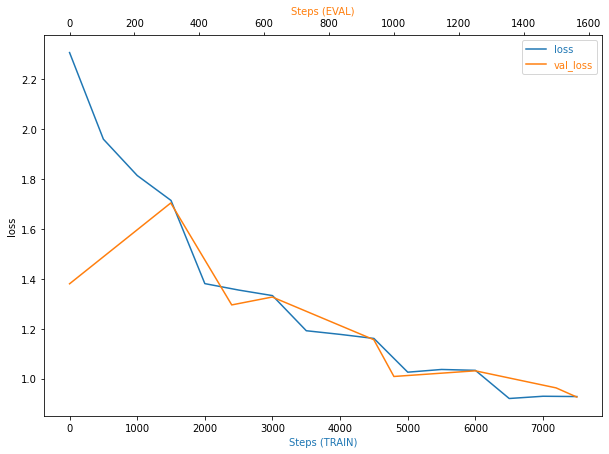

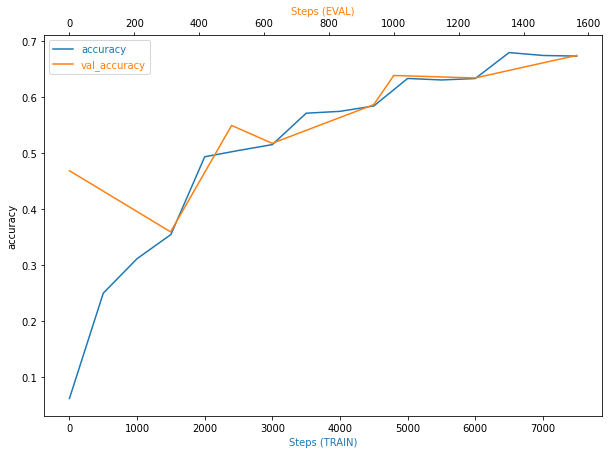

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):
    
    tensor_name=tensor_name
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    
    fig = plt.figure(figsize=(10,7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    p1, = host.plot(steps_train, vals_train, label=tensor_name)
    p2, = par.plot(steps_eval, vals_eval, label="val_"+tensor_name)

    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    
    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "loss")
plot_tensor(trial, "accuracy")

## Conclusion

In this tutorial, you learned how to use SageMaker Debugger with the minimal coding through SageMaker Studio and Jupyter notebook. The Debugger built-in rules detect training anomalies while concurrently reading in the output tensors, such as weights, activation outputs, gradients, accuracy, and loss, from your training jobs. In the next tutorial videos, you will learn more features of Debugger, such as how to analyze the tensors, change the built-in debugging rule parameters and thresholds, and save the tensors at your preferred S3 bucket URI.